Домашняя работа

Найти данные о заболеваемости/смертности/выздоровлении COVID-19 (они есть например на Kaggle) и использовать их для решения заданий. 

Можно использовать как данные по какому-то конкретному региону/стране, так и данные по всему миру.

Воспользуемся официальными данными по России с сайта  Johns Hopkins Centers for Civic Impact

In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import math

In [6]:
coronovirus=pd.read_csv("Documents/Data-science/corona.csv",sep=';')
coronovirus= coronovirus.drop('Unnamed: 0', 1)
coronovirus['Date'] = pd.to_datetime(coronovirus['date'])
coronovirus= coronovirus.drop('date', 1)
coronovirus = coronovirus.set_index('Date')
coronovirus= coronovirus.asfreq('D')
coronovirus['month'] = coronovirus.index.month
coronovirus['year'] = coronovirus.index.year
coronovirus= coronovirus.groupby(['year', 'month']).mean()
coronovirus

confirmed       death       recovery
year month                                         
2020 1          0.200000    0.000000       0.000000
     2          0.000000    0.000000       0.068966
     3         75.322581    0.548387       3.838710
     4       3472.033333   35.200000     383.266667
     5       9656.290323  116.774194    5169.806452
     6       8036.200000  153.766667    8003.000000
     7       6178.451613  149.451613    7265.935484
     8       4965.838710  102.870968    5487.806452
     9       5946.566667  116.733333    4914.966667
     10     14047.354839  230.870968    8182.322581
     11     22322.300000  390.133333   18501.766667
     12     27464.870968  541.290323   24652.548387
2021 1      21967.774194  508.322581   23770.612903
     2      13930.428571  452.535714   18014.785714
     3       9543.032258  403.838710   11280.129032
     4       8550.700000  369.033333    8626.500000
     5       8476.032258  360.451613    8159.903226
     6      14536.066667  450.300000   10394.066667
     7      23730.806452  741.258065   19274.322581
     8      20498.322581  776.032258 -178702.806452
     9      19346.900000  784.666667       0.000000
     10     26291.923077  914.538462       0.000000

Проверить ряд на стационарность. Привести ряд к стационарному виду.

Построить прогноз заболеваемости, используя модель ARIMA, на месяц вперед. Подобрать оптимальные параметры модели. Визуализировать результат. Выглядит ли такой прогноз реалистичным?

Выделим три датасета - с количеством смертельных случаев, заболеваемостью и численностью выздоровевших.

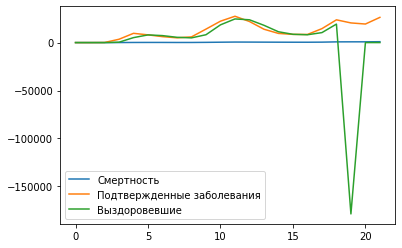

In [19]:
import matplotlib.pyplot as plt
plt.plot(coronovirus.death.values)
plt.plot(coronovirus.confirmed.values)
plt.plot(coronovirus.recovery.values)
plt.legend(['Смертность','Подтвержденные заболевания','Выздоровевшие'])

Проверить ряд на стационарность. Привести ряд к стационарному виду.

Построить прогноз заболеваемости, используя модель ARIMA, на месяц вперед. Подобрать оптимальные параметры модели. Визуализировать результат. Выглядит ли такой прогноз реалистичным?

Для решения задачи можно использовать pmdarima

Тесты дали разные результаты по ряду  'Подтвержденные случаи'.

In [20]:
alpha = 0.05
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(coronovirus.confirmed)

if p_value < alpha:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

Ряд стационарен


In [21]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(coronovirus.confirmed)

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


Ряд с выздоравлениями нестационарный

In [22]:
alpha = 0.05
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(coronovirus.recovery)

if p_value < alpha:
    print('Ряд стационарен')
else:
    print('Ряд нестационарен')


Ряд нестационарен


In [23]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(coronovirus.recovery)

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд нестационарен


Неопределенный результат и со смертями: KPSS = не стационарный и ADF = стационарный -> разностно-стационарный, используем разности, чтобы сделать ряд стационарным.

In [24]:
alpha = 0.05
stat, p_value, *_ = statsmodels.tsa.stattools.kpss(coronovirus.death)

if p_value < alpha:
    print('Ряд стационарен')
else:
    print('Ряд нестационарен')

Ряд стационарен


In [25]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(coronovirus.death)

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


Приведем к стацианарному:(ряд по смертности) с помощью разностей в нашем ряду и логарифмической функции:

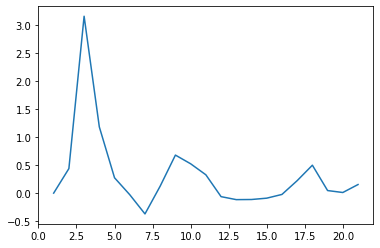

In [28]:
coronovirus['death_log'] = np.log(coronovirus['death']+1)
coronovirus['diff'] = coronovirus['death_log'] -  coronovirus['death_log'].shift(1)
coronovirus['diff']=coronovirus['diff'].dropna()
coronovirus['diff'].dropna()
plt.plot(coronovirus['diff'].values)


In [29]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(coronovirus['diff'].dropna())

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


Тот же самый метод для Подтвержденных случаев :

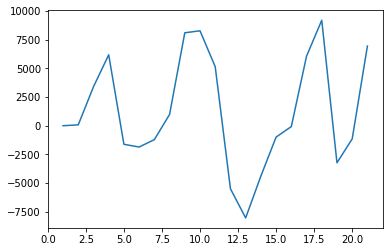

In [30]:
coronovirus['diff1'] = coronovirus['confirmed'] -  coronovirus['confirmed'].shift(1)
coronovirus['diff1']=coronovirus['diff1'].dropna()
coronovirus['diff1'].dropna()
plt.plot(coronovirus['diff1'].values)

In [31]:
stat, p_value, *_ = statsmodels.tsa.stattools.adfuller(coronovirus['diff1'].dropna())

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')

Ряд стационарен


Для случаев заражения попробуем применить дифференциирование.Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд

In [32]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

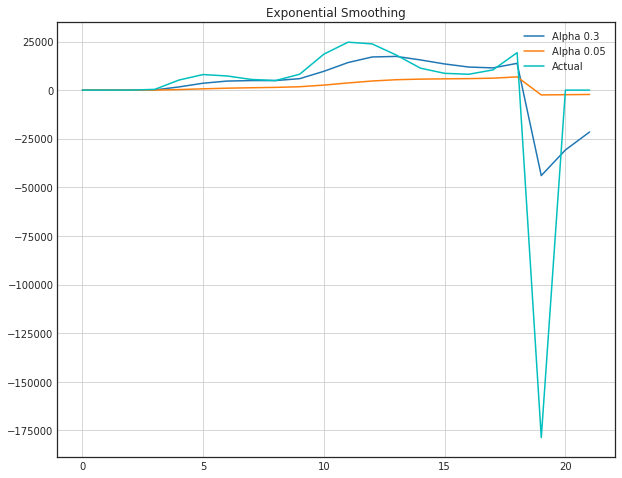

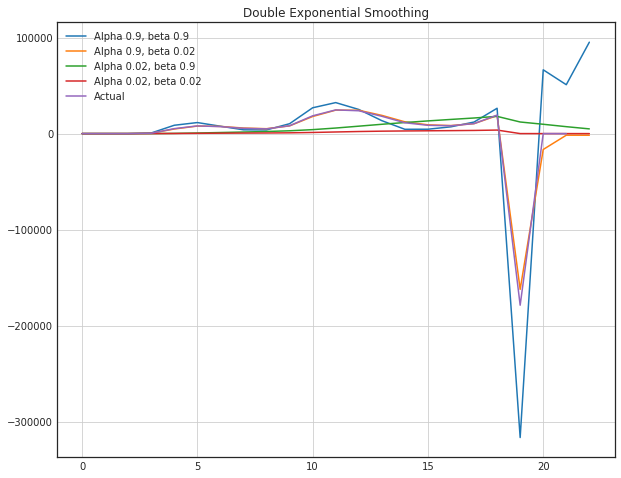

In [33]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(10, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(coronovirus.recovery, alpha), label="Alpha {}".format(alpha))
    plt.plot(coronovirus.recovery.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(10, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(coronovirus.recovery, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(coronovirus.recovery.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Как мы видим,чем меньше параметр $\alpha$, тем более сглаженным получается тренд , тогда как в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$, который равен параметру $\alpha$ при полном сглаживании тренда.Однако такие показатели не совсем хороши,так как они не отражают рельных изменений.Однако другими способами - разностью, дифференции рованием или логарифмированием не удалось привести тренд к стационарному виду. 

In [34]:
#double_exponential_smoothing(coronovirus.recovery, alpha=0.02, beta=0.9)
stat, p_value, *_ = double_exponential_smoothing(coronovirus.recovery, alpha=0.02, beta=0.9)

if p_value < alpha:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')


Ряд стационарен


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from itertools import product
import pmdarima as pm
corona=coronovirus[['confirmed','death','recovery']]
corona['death'] = (corona['death'] - corona['death'].mean()) / coronovirus['death'].std()
n_sample = len(corona.death)
pivot = int(0.7 * n_sample)
x_train, x_test = coronovirus.death.iloc[:pivot], coronovirus.death.iloc[pivot:]

In [113]:
arima_model = pm.auto_arima(x_train, 
                              start_p=1,d = 0,start_q=1,
                              test="adf", supress_warnings = True,
                              trace=True)
arima_model.summary()
#ARIMA(1,0,3) with AIC=190.789 - best model

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3.598, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=34.399, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10.466, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=38.441, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3.356, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3.024, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2.764, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4.762, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5.327, Time=0.08 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6.572, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1.507, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3.124, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3.475, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(3, 0, 0)   Log Likelihood                   3.247
Date:                Fri, 19 Nov 2021   AIC                              1.507
Time:                        11:38:24   BIC                              4.339
Sample:                             0   HQIC                             1.477
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8750      0.213      8.805      0.000       1.458       2.292
ar.L2         -1.3828      0.398     -3.475      0.001      -2.163      -0.603
ar.L3          0.4693      0.236      1.992      0.046       0.007       0.931
sigma2         0.0286      0.017      1.668      0.095      -0.005       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.85   Prob(JB):                         0.66
Heteroskedasticity (H):               2.46   Skew:                            -0.35
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

    Из-за небольшого количества данных, а также ненормальности распределения, даже после нормализации переменной, мы не получили нормализованой статистики.

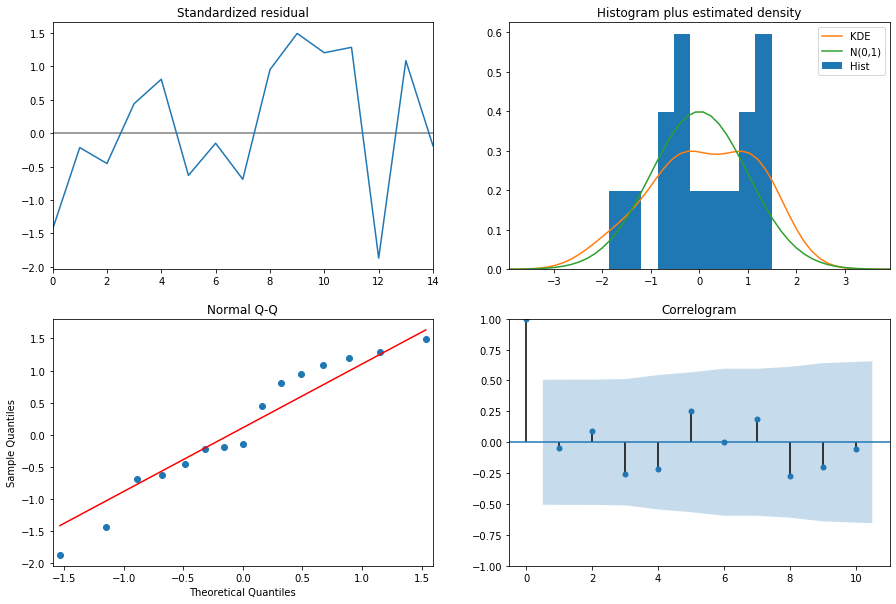

In [128]:
arima_model.plot_diagnostics(figsize=(15, 10))
plt.show()

In [161]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(x_train, order=(3,0,0)).fit()
x_pred = model.forecast(len(x_test))  
def plot_train_test_pred(train, test, pred):
    t_train = list(range(len(train)))
    t_test = list(range(len(train), len(train) + len(test)))
    plt.plot(t_train, train.values)
    plt.plot(t_test, test.values)
    plt.plot(t_test, pred.values)
    plt.legend(['train', 'test', 'pred'])
    test = np.arange(90, 120).reshape(-1, 1)


Даже при минимизации AIC наш прогноз совсем нереалистичен

AIC 2.7642824115815134 -2.42375375542308


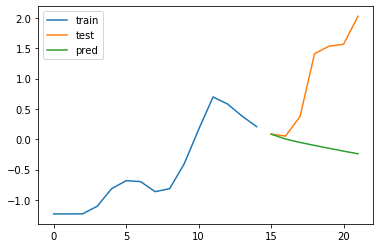

In [162]:
plot_train_test_pred(x_train, x_test, x_pred)
print("AIC",model.aic,r2_score(x_test, x_pred))

Попробкем с помощью  дифференциирования - получилось еще хуже

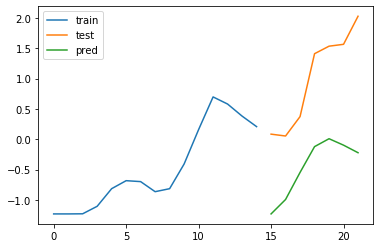

In [126]:
first_val = x_train.iloc[0]
x_train_diff = x_train.diff().dropna()
model = ARIMA(x_train_diff.values, order=(3,0,0)).fit()
x_pred_diff = model.forecast(len(x_test) - 1)
x_pred_diff = np.array([first_val] + x_pred_diff.tolist())
x_pred = pd.Series(np.cumsum(x_pred_diff))
plot_train_test_pred(x_train, x_test, x_pred)

In [130]:
r2_score(x_test, x_pred)

-3.0874705409225207

Применить градиентный бустинг для решения задачи. Используя кросс-валидацию, сравнить результаты ARIMA и бустинга.

In [320]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from numpy import asarray
from sklearn.model_selection import cross_val_score
xgb = XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300, 
                     colsample_bytree=0.8, subsample=0.8, eta=0.3, seed=42)
coronovirus=pd.read_csv("Documents/Data-science/corona.csv",sep=';')
coronovirus= coronovirus.drop('Unnamed: 0', 1)
coronovirus['date'] = pd.to_datetime(coronovirus['date'])
#coronovirus['month'] = coronovirus['date'].dt.month
#coronovirus['year'] = coronovirus['date'].dt.year
coronovirus['day'] = coronovirus['date'].dt.dayofyear
corona=coronovirus.drop(['recovery'], axis=1)
corona['death'] = (corona['death'] - corona['death'].mean()) / corona['death'].std()
corona['confirmed'] = (corona['confirmed'] - corona['confirmed'].mean()) / corona['confirmed'].std()
corona = corona.set_index('date')
x_df = corona[['confirmed']]
y_df = corona[["death"]]
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.8)
x_train.shape, x_test.shape
model=xgb.fit(x_train, y_train)
preds = xgb.predict(x_train)



In [308]:
score = xgb.score(x_train, y_train)
score

-1.9458372233494003e-05

Немного лучше, по сравнению с ARIMA

In [309]:
scores = cross_val_score(xgb,x_train, y_train, scoring='neg_mean_absolute_error', cv=3)
np.mean(scores)

-0.8435214661416145

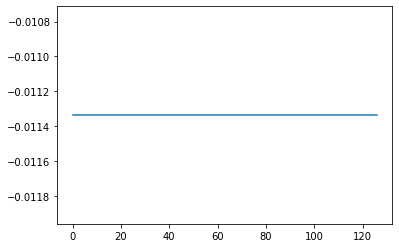